<a href="https://colab.research.google.com/github/Ronican/FIZ437E-Projects/blob/main/HomeWork%20%235.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

In [2]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [4]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

_SAMPLING_RATE = 24000

In [8]:
#Dataset taken from: https://github.com/MTG/SymbTr
!unzip midi.zip

Archive:  midi.zip
  inflating: midi/acemasiran--aranagme--agiraksak--1--.mid  
  inflating: midi/acemasiran--aranagme--aksak--1--.mid  
  inflating: midi/acemasiran--aranagme--curcuna--1--.mid  
  inflating: midi/acemasiran--aranagme--semai--1--.mid  
  inflating: midi/acemasiran--aranagme--senginsemai--1--.mid  
  inflating: midi/acemasiran--aranagme--sofyan--1--.mid  
  inflating: midi/acemasiran--aranagme--yuruksemai--1--.mid  
  inflating: midi/acemasiran--beste--devrikebir--ber_kusa-yi--basmaci_abdi_efendi.mid  
  inflating: midi/acemasiran--beste--zencir--hayatin_cumleye--dellalzade_haci_ismail_efendi.mid  
  inflating: midi/acemasiran--fantezi--yuruksemai_ii--ey_benim--resat_erer.mid  
  inflating: midi/acemasiran--ilahi--muhammes--ta_dil--calakzade_mustafa_efendi.mid  
  inflating: midi/acemasiran--kupe--aksaksemai--bir--ahmet_avni_konuk.mid  
  inflating: midi/acemasiran--mars--nimsofyan--korkma_sonmez--ali_rifat_cagatay.mid  
  inflating: midi/acemasiran--nakis--yuruksemai--

In [10]:
data_dir = pathlib.Path('midi')
filenames = glob.glob(str(data_dir/'*.mid*'))
print('Number of files:', len(filenames))

Number of files: 2200


In [11]:
sample_file = filenames[1]
print(sample_file)

midi/gerdaniye--turku--kapali_curcuna--daglar_basi--kerkuk.mid


In [13]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [14]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
 
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [15]:
display_audio(pm)


In [16]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [17]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=79, note_name=G5, duration=0.2591
1: pitch=78, note_name=F#5, duration=0.1290
2: pitch=79, note_name=G5, duration=0.2591
3: pitch=81, note_name=A5, duration=0.2591
4: pitch=78, note_name=F#5, duration=0.6477
5: pitch=76, note_name=E5, duration=0.1290
6: pitch=78, note_name=F#5, duration=0.2591
7: pitch=79, note_name=G5, duration=0.2591
8: pitch=76, note_name=E5, duration=0.6477
9: pitch=74, note_name=D5, duration=0.1290


In [18]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [19]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     79  0.000000  0.259091  0.000000  0.259091
1     78  0.272727  0.401704  0.272727  0.128977
2     79  0.408522  0.667613  0.135795  0.259091
3     81  0.681249  0.940340  0.272727  0.259091
4     78  0.953976  1.601703  0.272727  0.647727

In [20]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['G5', 'F#5', 'G5', 'A5', 'F#5', 'E5', 'F#5', 'G5', 'E5', 'D5'],
      dtype='<U3')

In [21]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

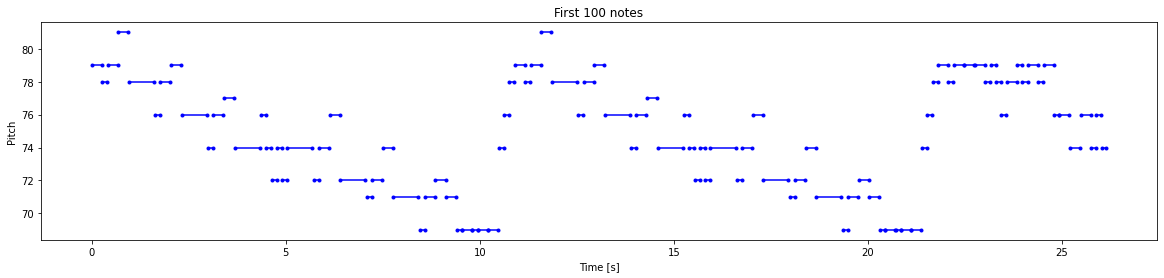

In [22]:
plot_piano_roll(raw_notes, count=100)

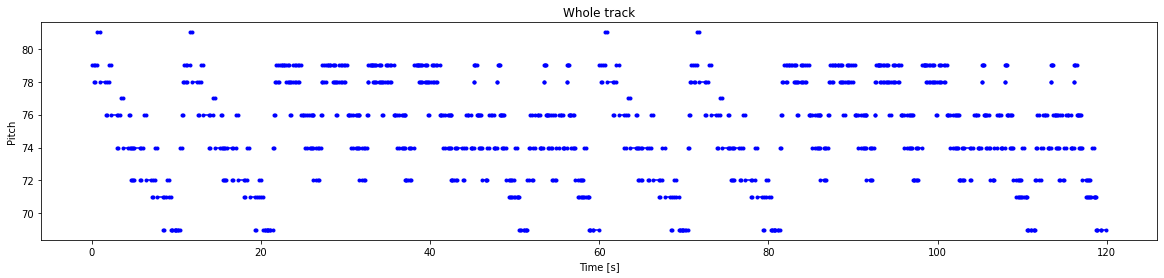

In [23]:
plot_piano_roll(raw_notes)

In [24]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

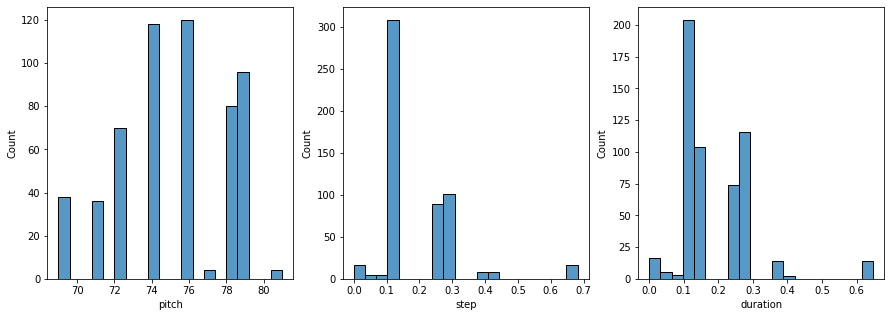

In [25]:
plot_distributions(raw_notes)

In [26]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [27]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [28]:
display_audio(example_pm)

In [32]:
num_files = 500
all_notes = []
for f in filenames[:num_files]:
    try:
      notes = midi_to_notes(f)
      all_notes.append(notes)
    except:
      True
all_notes = pd.concat(all_notes)

In [33]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 176086


In [34]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [35]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [36]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [37]:
seq_length = 75
vocab_size = 512
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(75, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [38]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (75, 3)
sequence elements (first 10): tf.Tensor(
[[0.140625   0.         0.59374976]
 [0.14453125 0.62499975 0.19791659]
 [0.13867188 0.20833325 0.20833325]
 [0.14453125 0.4166665  0.20833325]
 [0.140625   0.4166665  0.19791659]
 [0.14453125 0.20833325 0.19791659]
 [0.140625   0.20833325 0.19791659]
 [0.14453125 0.20833325 0.19791659]
 [0.13867188 0.20833325 0.20833325]
 [0.14453125 0.4166665  0.20833325]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=79.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.20833324999999903>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.19791658749999996>}


In [39]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [40]:
train_ds.element_spec

(TensorSpec(shape=(64, 75, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [41]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [42]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [43]:
losses = model.evaluate(train_ds, return_dict=True)
losses

2750/2750 [==============================] - 188s 53ms/step - loss: 5.3008 - duration_loss: 0.2215 - pitch_loss: 4.8392 - step_loss: 0.2401


{'duration_loss': 0.22152192890644073,
 'loss': 5.300754070281982,
 'pitch_loss': 4.83917760848999,
 'step_loss': 0.2400609850883484}

In [54]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':30.0,
    },
    optimizer=optimizer,
)

In [55]:
model.evaluate(train_ds, return_dict=True)

2750/2750 [==============================] - 148s 53ms/step - loss: 2.8087 - duration_loss: 0.0900 - pitch_loss: 1.9877 - step_loss: 0.0095


{'duration_loss': 0.08999335020780563,
 'loss': 2.808661460876465,
 'pitch_loss': 1.9877190589904785,
 'step_loss': 0.009473553858697414}

In [56]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [57]:
%%time
epochs = 5

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/5
2750/2750 [==============================] - 342s 124ms/step - loss: 2.9666 - duration_loss: 0.0947 - pitch_loss: 2.2780 - step_loss: 0.0120
Epoch 2/5
2750/2750 [==============================] - 339s 123ms/step - loss: 2.8803 - duration_loss: 0.0920 - pitch_loss: 2.1875 - step_loss: 0.0118
Epoch 3/5
2750/2750 [==============================] - 338s 123ms/step - loss: 2.9184 - duration_loss: 0.0931 - pitch_loss: 2.2725 - step_loss: 0.0118
Epoch 4/5
2750/2750 [==============================] - 337s 123ms/step - loss: 3.5298 - duration_loss: 0.1087 - pitch_loss: 4.5315 - step_loss: 0.0416
Epoch 5/5
2750/2750 [==============================] - 341s 124ms/step - loss: 3.3590 - duration_loss: 0.1055 - pitch_loss: 3.2181 - step_loss: 0.0327
CPU times: user 44min 11s, sys: 2min 46s, total: 46min 57s
Wall time: 28min 59s


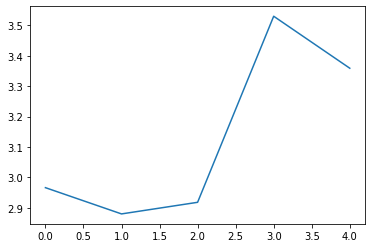

In [58]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [59]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [60]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [61]:
generated_notes.head(10)

pitch      step  duration     start       end
0     74  0.021267  0.254866  0.021267  0.276133
1     86  0.000000  0.055128  0.021267  0.076396
2     81  0.000000  0.070112  0.021267  0.091380
3     83  0.000000  0.044188  0.021267  0.065455
4     82  0.000000  0.052803  0.021267  0.074070
5     86  0.000000  0.039375  0.021267  0.060642
6     86  0.000000  0.062907  0.021267  0.084174
7     86  0.000000  0.059236  0.021267  0.080503
8     84  0.000000  0.032385  0.021267  0.053652
9     81  0.000000  0.046813  0.021267  0.068081

In [62]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [63]:
from google.colab import files
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

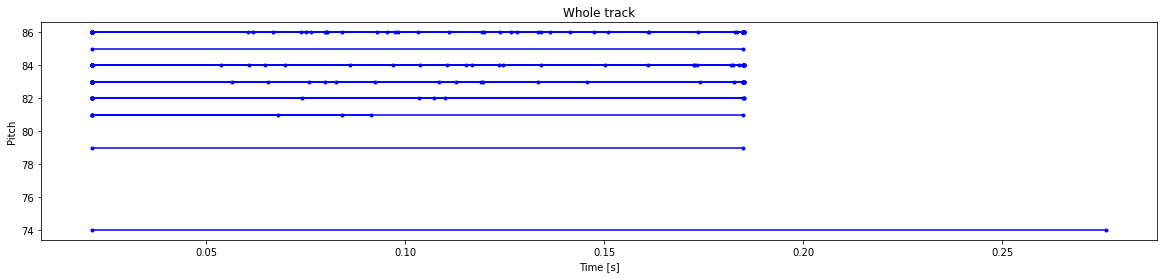

In [64]:
plot_piano_roll(generated_notes)

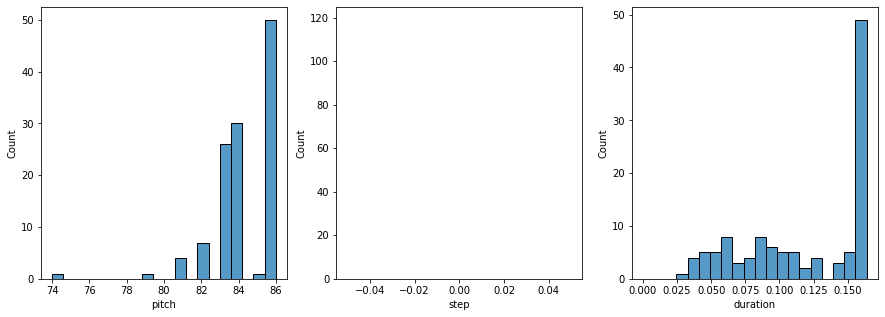

In [65]:
plot_distributions(generated_notes)